Importing libraries

In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import os
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
new_lfc = pd.read_csv('~/Documents/repos/mtb_tn_db/data/standardized_data/cleaned_ML/lfc_mb_filt.csv')
new_lfc.head()

,Rv_ID,129s1.SvImJ_vs_C57BL.6J,129s1.SvImJ_vs_mbio_H37Rv,A.J_vs_129s1.SvImJ,A.J_vs_C57BL.6J,A.J_vs_mbio_H37Rv,C57BL.6J_vs_129s1.SvImJ,C57BL.6J_vs_A.J,C57BL.6J_vs_C57BL.6J,C57BL.6J_vs_mbio_H37Rv,...,zhang_DETA-NO_pH_7.0_vs_zhang_pH_7.0_no_NO_control,zhang_Fe_1.5mM_vs_zhang_Fe_450uM,zhang_Trp_Rescue_vs_zhang_in_vitro_control_Rescue,zhang_Tyloxapol_pH_6.5_vs_zhang_Tyloxapol_pH_4.5,zhang_Tyloxapol_pH_6.5_vs_zhang_pcit_pH_4.5,zhang_mhcii_mouse_d10_vs_zhang_wt_mouse_d10,zhang_mhcii_mouse_d45_vs_zhang_wt_mouse_d45,zhang_wt_mouse_d10_vs_zhang_input_library,zhang_wt_mouse_d45_vs_zhang_input_library,Functional_Category
0,Rv0001,0.00,-0.18,0.00,0.00,-0.18,0.00,0.00,0.0,-0.18,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
1,Rv0002,0.00,-0.07,0.00,0.00,-0.07,0.00,0.00,0.0,-0.07,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,information pathways
2,Rv0003,1.54,-1.86,-0.99,0.56,-2.85,-1.54,-0.56,0.0,-3.41,...,-0.31,1.09,-2.13,0.51,0.41,1.30,-0.49,-1.26,-2.25,information pathways
3,Rv0005,-0.56,-0.58,-0.08,-0.64,-0.65,0.56,0.64,0.0,-0.02,...,-0.89,-2.36,-1.89,2.90,2.20,-4.05,0.30,0.69,-3.55,information pathways
4,Rv0006,0.78,2.77,-0.55,0.23,2.22,-0.78,-0.23,0.0,1.99,...,0.23,-1.51,4.80,-2.90,-2.05,-2.93,0.87,3.70,3.67,information pathways


Function that Outputs the Accuracy Matrix and an Accuracy Score

In [5]:
def accuracy_matrix(classname, C_temp, shuffle, model):
    #Creating the y variable. 
    y_list = []
    i = 0
    for gene in new_lfc.Functional_Category:
        if gene == classname:
            y_list.append(1)
        else:
            y_list.append(0)
        i+=1
    y = np.array(y_list)
    
    #Shuffling the y matrix. 
    if shuffle == True:
            random.shuffle(y)
            
    #Creating the x variable.
    raw_x= new_lfc.drop(["Rv_ID", "Functional_Category"], axis = 1)
    X = raw_x.to_numpy()

    #Step 1: Create Logistic REgression Classifier.
    clf = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=C_temp, random_state=42)
    #Step 2: Split samples into training and test sets using STratifiedKFOld
    n_splits_Temp = 5
    n_classes = 2
    skf = StratifiedKFold(n_splits=n_splits_Temp, shuffle=True, random_state=42)
    confusion = np.zeros((n_classes, n_classes))
    log_loss_var = []
    #Step 3: ITerate thru each training/test set.
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        #Step 4: Fit the logistic regression to the training data. 
        if model == "logreg":
            clf.fit(X_train, y_train)
        elif model == "xgboost"
            clf = XGBClassifier()
        clf.fit(X_train, y_train)
        #Step 5: Predict the values of the testing data. 
        y_hat = clf.predict(X_test)
        confusion += confusion_matrix(y_test, y_hat)
        #Create a list of all the accuracy matrixes.
        y_pred = clf.predict_proba(X_test)
        log_loss_var.append(log_loss(y_test, y_pred))
    average_logloss = sum(log_loss_var)/len(log_loss_var)

    confusion = normalize(confusion, axis=1, norm='l1')

    col_names = list(clf.classes_)
    df_confusion = pd.DataFrame(confusion, columns=col_names, index=col_names)

    #plt.figure(figsize=(12,12))
    
    #rc = {'xtick.labelsize': 22, 'ytick.labelsize': 22, 'axes.labelsize': 22}
    #sns.set(rc=rc)
    #heat = sns.heatmap(df_confusion, annot=True, linewidths=2, fmt='1.2f', square=True, annot_kws={"fontsize":12})
    #if "/" in classname:
        #classname = classname.split("/")
    #if shuffle == True:
        #filename = str(classname)+","+str(C_temp)+"_shuffle"+".png"
    #elif shuffle == False:
        #filename = str(classname)+","+str(C_temp)+"_real"+".png"
    #plt.savefig(filename)
    return average_logloss


Creating a matrix with combination of classifier and C values

In [6]:
Fxnal_Categories = list(new_lfc.Functional_Category.unique())
C_values =[0.01, 0.1, 1]
Bool = [True, False]

Possible_Matrices = []
for Category in Fxnal_Categories:
    for C in C_values:
        for val in Bool:
            Combo =[]
            Combo.extend([Category,C,val])
            Possible_Matrices.append(Combo)

print(Possible_Matrices)

[['information pathways', 0.001, True], ['information pathways', 0.001, False], ['information pathways', 0.01, True], ['information pathways', 0.01, False], ['information pathways', 0.1, True], ['information pathways', 0.1, False], ['information pathways', 1, True], ['information pathways', 1, False], ['cell wall and cell processes', 0.001, True], ['cell wall and cell processes', 0.001, False], ['cell wall and cell processes', 0.01, True], ['cell wall and cell processes', 0.01, False], ['cell wall and cell processes', 0.1, True], ['cell wall and cell processes', 0.1, False], ['cell wall and cell processes', 1, True], ['cell wall and cell processes', 1, False], ['intermediary metabolism and respiration', 0.001, True], ['intermediary metabolism and respiration', 0.001, False], ['intermediary metabolism and respiration', 0.01, True], ['intermediary metabolism and respiration', 0.01, False], ['intermediary metabolism and respiration', 0.1, True], ['intermediary metabolism and respiration',

Running Through Each Matrix and Saving the Log Loss

In [7]:
ReallogLoss = []
Shufflelogloss = []

for matrix in Possible_Matrices:
    average_logloss = accuracy_matrix(matrix[0], matrix[1], matrix[2])
    if matrix[2] == False:
        ReallogLoss.append(average_logloss)
    elif matrix[2] == True:
        Shufflelogloss.append(average_logloss)


Creating an Error Bar for Shuffled Date

In [ ]:
shuffle_bool = [] 
for i in range(0,11):
    shuffle_bool.append(True)
    
errorbar_upper = []
errorbar_lower = []

for Category in Fxnal_Categories:
    for C in C_values:
        Shuffle_Possible = []
        shuffle_logloss_range = []
        for val in shuffle_bool:
            Combo =[]
            Combo.extend([Category,C,val])
            Shuffle_Possible.append(Combo)

        for matrix in Shuffle_Possible:
            shuffle_logloss = accuracy_matrix(matrix[0], matrix[1], matrix[2])
            shuffle_logloss_range.append(shuffle_logloss)
        error_max = np.percentile(shuffle_logloss_range, 95)
        error_min = np.percentile(shuffle_logloss_range, 5)
        errorbar_upper.append(error_max)
        errorbar_lower.append(error_min)


Creating a Data Frame of LogLoss Values for each C 

In [ ]:
Categories = []
C_parameters = []
for matrix in Possible_Matrices:
    if matrix[2] == True:
        Categories.append(matrix[0])
        C_parameters.append(matrix[1])
data= {'c':C_parameters,'Real_Data':ReallogLoss, 'Shuffle_Data':Shufflelogloss, 'ErrorBar_Upper': errorbar_upper, 'ErrorBar_Lower': errorbar_lower} #Creating a data frame with all the C values.
df_LogLoss = pd.DataFrame(data,index = [Categories])
df_COOO1 = df_LogLoss[df_LogLoss.c == 0.001] #Making a data frame for each c value.
df_COO1 = df_LogLoss[df_LogLoss.c == 0.01]
df_CO1 = df_LogLoss[df_LogLoss.c == 0.1]
df_C1 = df_LogLoss[df_LogLoss.c == 1]
df_list = [df_COOO1, df_COO1, df_CO1, df_C1]
df_LogLoss

Creating a Scatterplot with Real and Shuffled Data

In [ ]:
def scatterlog_loss(df):
    plt.figure(figsize = (6,6))
    plt.scatter(df.SHuffle_Data, df.Real_Data)
    plt.xlim(0.3,0.8)
    plt.ylim(0.3,0.8)
    xyline = np.linspace(0.3,0.8,20)
    plt.plot(xyline, xyline)
    plt.xlabel('logloss real data', fontsize = 22)
    plt.ylabel('logloss shuffled data', fontsize = 22)
    xt = plt.xticks(fontsize = 14)
    yt = plt.yticks(fontsize = 14)
    plt.errorbar(df.Real_Data, df.Shuffle_Data, yerr= df.Error, fmt='o')

In [ ]:
scatterlog_loss(df_COOO1)

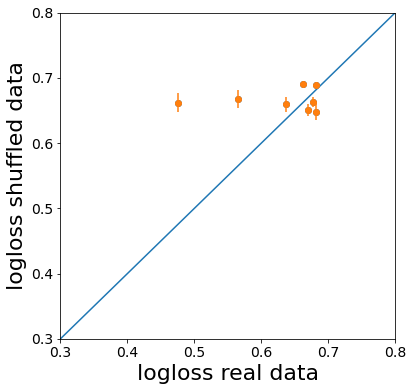

In [37]:
scatterlog_loss(df_COO1)

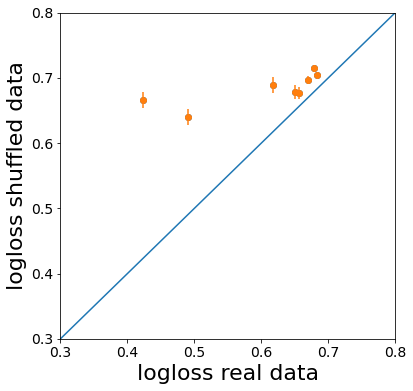

In [38]:
scatterlog_loss(df_CO1)

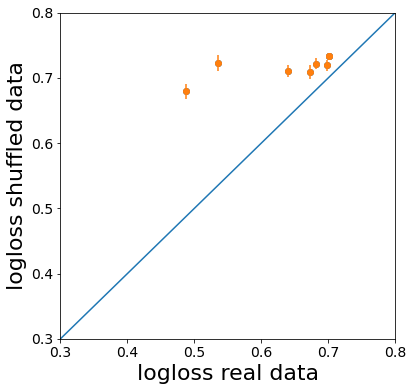

In [39]:
scatterlog_loss(df_C1)

### 